In [47]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)
from itertools import cycle
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.debugger import set_trace

%matplotlib inline
%pdb

Automatic pdb calling has been turned ON


In [2]:
cmap = cm.get_cmap('Blues_r')
matplotlib.style.use('ggplot')
#print(plt.style.available)
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams.update({'figure.autolayout': True})

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [4]:

def evaluate_lstm(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_):
    return evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, 'LSTM')

def view_data(name, past_scores, model_type=''):
    _, _, df = get_result(past_scores)
    display(name)


    group_by = 'no_of_features'
    if(model_type == 'LSTM'):
        group_by = 'hidden_layers'
    df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=[group_by])

    df1 = df1.first().loc[:,['f1_score', 'f1_score_20', 'time_taken']]

    if(model_type == 'LSTM'):

        df1 = df1.rename(index={1:"Shallow", 3:"Deep"})
        df1.index.rename('LSTM Type', inplace=True)

    else: 
        df1 = df1.rename(index={1:"One", 12:"10%", 24:"20%", 48:"40%", 122:"All"})

    df1 = df1.rename(columns={"f1_score":"F Score(Test+)", "f1_score_20":"F Score(Test-)", "time_taken":"Duration(secs)"})
    display(df1)
    plot = df1.drop("Duration(secs)", axis=1).plot(kind='bar', rot=0,  legend=False, 
                    figsize=[10,4], cmap=cmap, fontsize='xx-large', edgecolor='black')#,figsize=(10, 10))
    plot.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, fontsize='xx-large')
    plotx = plot.twinx()
    plot1 = df1.loc[:,"Duration(secs)"].plot(kind='line', linestyle='--', rot=0,  
                                                    legend=False,cmap=cmap, fontsize='xx-large',
                                                    ax=plotx)#,figsize=(10, 10))
    plot1.legend(loc="lower left", ncol=3, fontsize='xx-large')
    display_and_save(name, plot1)
    return df1

def get_best_df(past_scores):
    psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
    df = psg.first().sort_values(by='f1_score', ascending=False)
    return df

def get_result(past_scores):

    df = get_best_df(past_scores)

    #epoch_nof_hidden
    key = int(df.iloc[0]['epoch'])
    nof = int(df.iloc[0].name[0])
    hidden = int(df.iloc[0].name[1])
    return "{}_{}_{}".format(key, nof, hidden), nof, df

def plot_auc(y_true, y_pred):
    y_true = y_true.astype(type(""))
    y_pred = y_pred.astype(type(""))

    y_true_oh = pd.get_dummies(y_true).values
    y_pred_oh = pd.get_dummies(y_pred, categories = [0,1]).values
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in [0,1]:
        fpr[i], tpr[i], _ = me.roc_curve(y_true_oh[:,i], y_pred_oh[:,i])
        roc_auc[i] = me.auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = me.roc_curve(y_true_oh.ravel(), y_pred_oh.ravel())
    roc_auc["micro"] = me.auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    colors = cycle(['aqua', 'cornflowerblue'])
    for i, color in zip([0,1], colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve for {0} (area = {1:0.2f})'
                 ''.format("Normal" if i == 0 else "Attack", roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    display(plt.show())

def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    #plot_auc(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}

def accumulate_scenarios(predictions, past_scores, model, scenario):
    key, nof, df = get_result(past_scores)
    y_true = predictions[key]["Actual"]
    y_pred = predictions[key]["Prediction"]
    scores = get_score(y_true, y_pred)
    scores.update({"Model":model,"Scenarios":scenario,"Number of Features":nof, "Duration(secs)":df.iloc[0]['time_taken']})

    return pd.DataFrame(scores, index=[1])


def display_and_save(name, plot):
    fig = plot.get_figure()
    #fig.savefig("result_plots/{}.eps".format(name.replace(":","").strip()), format='eps', dpi=1000)
    fig.savefig("result_plots/{}.png".format(name.replace(":","").strip()), format='png', dpi=1000)
    display(plot)

    
    
def evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, model_type='AE'):
    all_scenarios = pd.DataFrame(columns=['Scenarios', 'Number of Features', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Duration(secs)'])
            
    #display("Individual Results for each Scenario")    
    results = view_data("Results for {} Train+".format(model),past_scores)
    results20 = view_data("Results for {} Train-".format(model),past_scores_20)

    display("Combined Results from all Scenarios for {}".format(model))

    scenario = "Train+/Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, model, scenario))
    
    scenario = "Train+/Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_, past_scores, model, scenario))
    
    scenario = "Train-/Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20, past_scores_20, model, scenario))
    
    scenario = "Train-/Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20_, past_scores_20, model, scenario))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))
    
    return all_scenarios
    
    
    
    

In [5]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")


'Results for FCN Train+'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.7492,0.6508,10.8948
10%,0.8571,0.8392,16.9951
20%,0.8728,0.8316,6.6152
40%,0.8739,0.8350,18.9799
All,0.8684,0.8410,4.3544


'Results for FCN Train-'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.3772,0.2880,5.7566
10%,0.7044,0.5874,8.0408
20%,0.8480,0.7952,5.3462
40%,0.8695,0.8396,0.6421
All,0.8364,0.7840,3.9727


'Combined Results from all Scenarios for FCN'

Accuracy  Duration(secs)  F1 Score  \
Model Scenarios    Number of Features                                       
FCN   Train+/Test+ 48                    0.8670         18.9799    0.8739   
      Train+/Test- 48                    0.7576         18.9799    0.8350   
      Train-/Test+ 48                    0.8561          0.6421    0.8695   
      Train-/Test- 48                    0.7504          0.6421    0.8396   

                                       Precision  Recall  
Model Scenarios    Number of Features                     
FCN   Train+/Test+ 48                     0.9490  0.8098  
      Train+/Test- 48                     0.9424  0.7495  
      Train-/Test+ 48                     0.8988  0.8420  
      Train-/Test- 48                     0.8856  0.7981

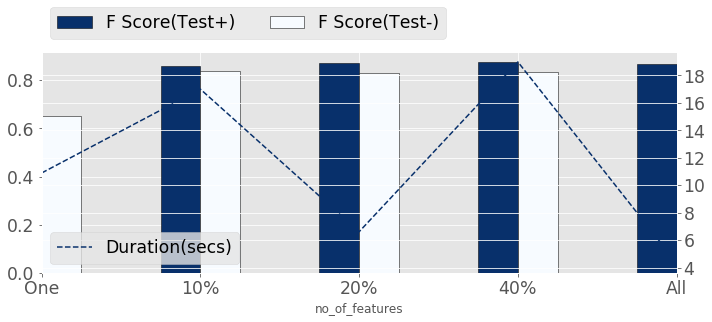

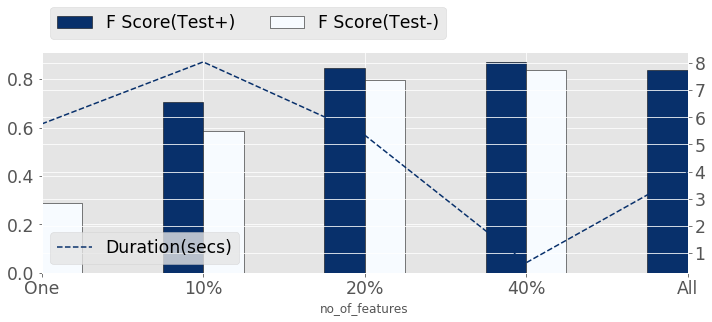

In [6]:
all_scenarios_fcn = evaluate("FCN", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [7]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-__.pkl")

'Results for VAE-Softmax Train+'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.7918,0.8054,19.0764
10%,0.8991,0.8743,40.3995
20%,0.8903,0.8643,27.2753
40%,0.7320,0.6515,28.7957
All,0.9036,0.8814,88.6219


'Results for VAE-Softmax Train-'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.8001,0.7782,39.1019
10%,0.8741,0.8692,41.8303
20%,0.8715,0.8393,4.2602
40%,0.8975,0.8700,10.4086
All,0.7368,0.6601,1.7788


'Combined Results from all Scenarios for VAE-Softmax'

Accuracy  Duration(secs)  \
Model       Scenarios    Number of Features                             
VAE-Softmax Train+/Test+ 122                   0.8948         88.6219   
            Train+/Test- 122                   0.8173         88.6219   
            Train-/Test+ 48                    0.7195         10.4086   
            Train-/Test- 48                    0.8015         10.4086   

                                             F1 Score  Precision  Recall  
Model       Scenarios    Number of Features                               
VAE-Softmax Train+/Test+ 122                   0.9036     0.9441  0.8665  
            Train+/Test- 122                   0.8814     0.9402  0.8296  
            Train-/Test+ 48                    0.6942     0.9151  0.5592  
            Train-/Test- 48                    0.8700     0.9373  0.8118

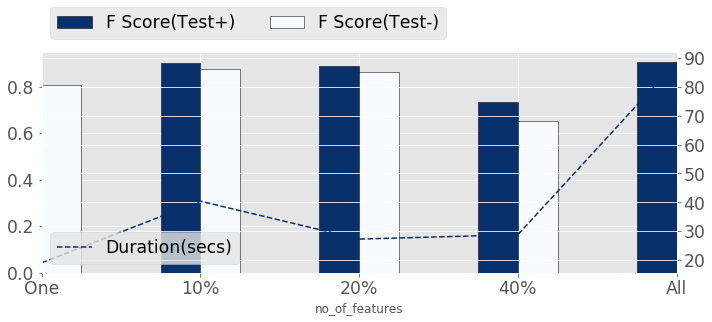

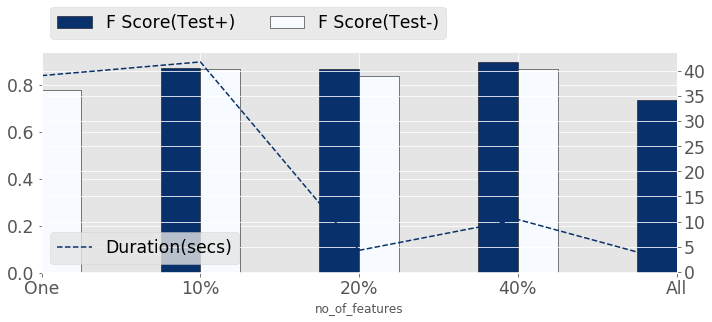

In [8]:
all_scenarios_vae_sm = evaluate("VAE-Softmax", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [9]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-__.pkl")

'Results for VAE-Label Train+'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.7255,0.9001,1.8554
10%,0.0017,0.0010,39.5257
20%,0.6778,0.7922,120.1837
40%,0.4421,0.4869,19.5371
All,0.6667,0.7915,158.8168


'Results for VAE-Label Train-'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,0.7255,0.9001,2.1003
10%,0.3398,0.3614,4.6407
20%,0.6374,0.7816,14.5815
40%,0.5402,0.6203,24.7774
All,0.5413,0.6541,3.2477


'Combined Results from all Scenarios for VAE-Label'

Accuracy  Duration(secs)  F1 Score  \
Model     Scenarios    Number of Features                                       
VAE-Label Train+/Test+ 1                     0.5692          1.8554    0.7255   
          Train+/Test- 1                     0.8184          1.8554    0.9001   
          Train-/Test+ 1                     0.5692          2.1003    0.7255   
          Train-/Test- 1                     0.8184          2.1003    0.9001   

                                           Precision  Recall  
Model     Scenarios    Number of Features                     
VAE-Label Train+/Test+ 1                      0.5692     1.0  
          Train+/Test- 1                      0.8184     1.0  
          Train-/Test+ 1                      0.5692     1.0  
          Train-/Test- 1                      0.8184     1.0

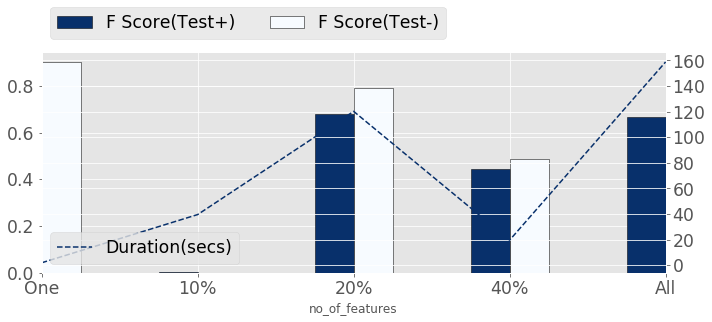

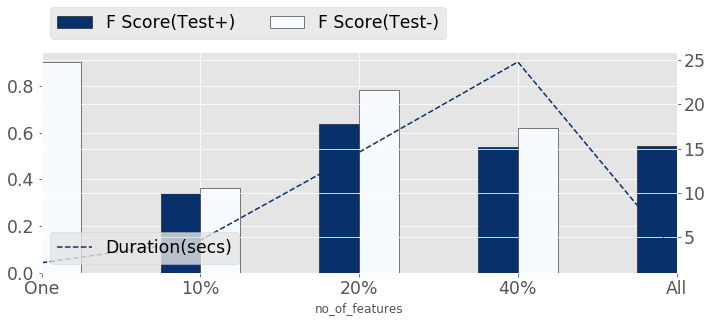

In [10]:
all_scenarios_vae = evaluate("VAE-Label", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [36]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-__.pkl")

'Results for LSTM-Seq2Seq Train+'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,1.0,1.0,24.9541


'Results for LSTM-Seq2Seq Train-'

,F Score(Test+),F Score(Test-),Duration(secs)
no_of_features,,,
One,1.0,1.0,15.2373


'Combined Results from all Scenarios for LSTM-Seq2Seq'

Accuracy  Duration(secs)  \
Model        Scenarios    Number of Features                             
LSTM-Seq2Seq Train+/Test+ 1                     0.9949         24.9541   
             Train+/Test- 1                     0.9949         24.9541   
             Train-/Test+ 1                     0.9992         15.2373   
             Train-/Test- 1                     0.9992         15.2373   

                                              F1 Score  Precision  Recall  
Model        Scenarios    Number of Features                               
LSTM-Seq2Seq Train+/Test+ 1                     0.9955     0.9915  0.9995  
             Train+/Test- 1                     0.9955     0.9915  0.9995  
             Train-/Test+ 1                     0.9993     0.9985  1.0000  
             Train-/Test- 1                     0.9993     0.9985  1.0000

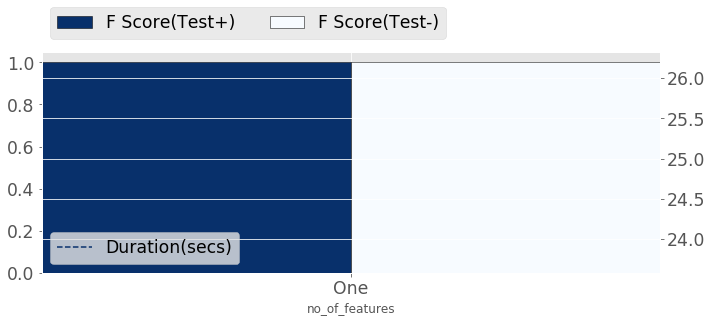

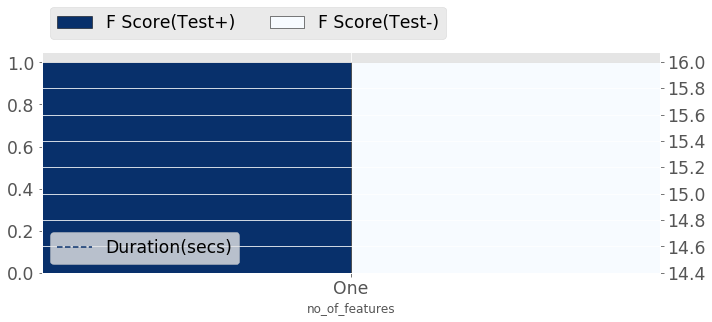

In [37]:
all_scenarios_lstm = evaluate_lstm("LSTM-Seq2Seq", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

'LSTM-Seq2Seq'

,F Score(Test+),F Score(Test-),Duration(secs)
LSTM Type,,,
Shallow,0.937,0.9153,21.5624
Deep,1.000,1.0000,24.9541


'LSTM-Seq2Seq'

,F Score(Test+),F Score(Test-),Duration(secs)
LSTM Type,,,
Shallow,0.9243,0.898,11.2495
Deep,1.0000,1.000,15.2373


'LSTM-Seq2Seq'

,F Score(Test+),F Score(Test-),Duration(secs)
LSTM Type,,,
Shallow,0.937,0.9153,21.5624
Deep,1.000,1.0000,24.9541


'LSTM-Seq2Seq'

,F Score(Test+),F Score(Test-),Duration(secs)
LSTM Type,,,
Shallow,0.9243,0.898,11.2495
Deep,1.0000,1.000,15.2373


LSTM Type,Deep,Shallow
variable,,
Train+/Test+,1.0,0.9370
Train+/Test-,1.0,0.9153
Train-/Test+,1.0,0.9243
Train-/Test-,1.0,0.8980


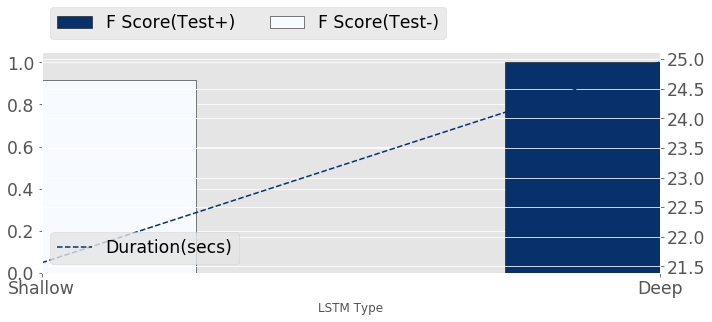

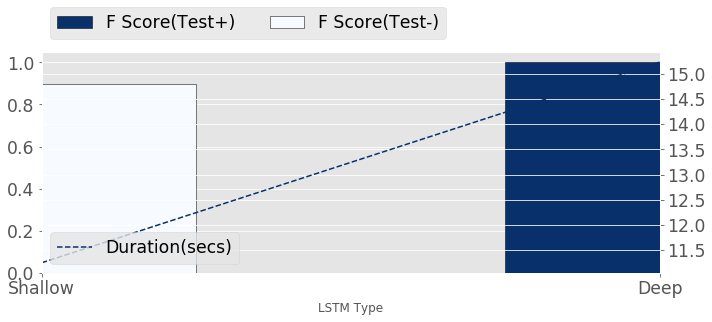

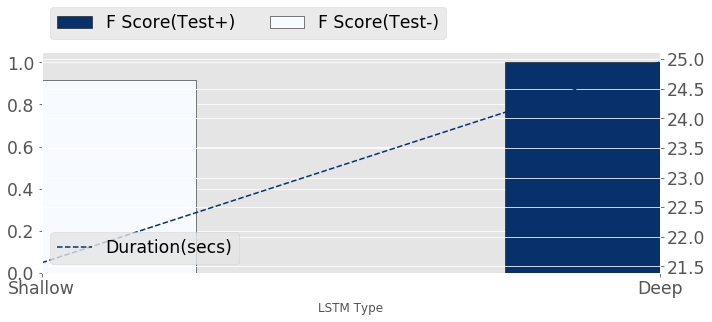

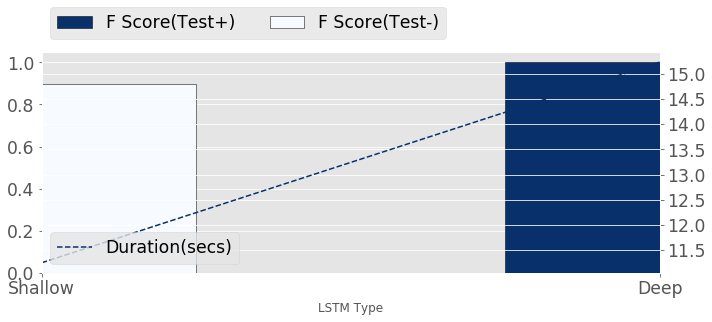

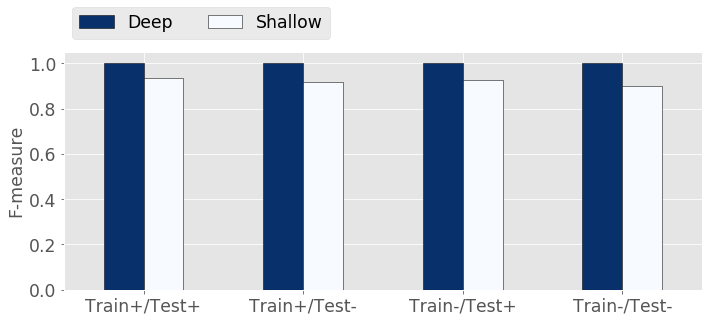

In [80]:

def get_score_for_bar(result, append):
    t = result.reset_index()
    t.rename(columns={"F Score(Test+)":"Test+", "F Score(Test-)":"Test-"}, inplace=True)
    t = t.melt(value_vars=['Test+', 'Test-'], id_vars=['LSTM Type'] )
    t.replace(to_replace={"Test+":"{}/Test+".format(append), "Test-":"{}/Test-".format(append)}, inplace=True)
    return t.loc[:,["variable", "value", "LSTM Type"]]

def get_time_for_bar(result, append):
    t = result.reset_index()
    t.rename(columns={"F Score(Test+)":"Test+", "F Score(Test-)":"Test-"}, inplace=True)
    t = t.melt(value_vars='Duration(secs)', id_vars='LSTM Type' )
    t.replace(to_replace={"Test+":"{}/Test+".format(append), "Test-":"{}/Test-".format(append)}, inplace=True)
    return t.loc[:,["variable", "value", "LSTM Type"]]

def get_shallow_network_data(type='score'):

    result = view_data("LSTM-Seq2Seq", past_scores, 'LSTM')
    result20 = view_data("LSTM-Seq2Seq", past_scores_20, 'LSTM')

    if(type=='time'):
        result=get_time_for_bar(result, "Train+")
        result.loc[:,'Scenarios'] = ['Train+', 'Train+']
        result20=get_time_for_bar(result20, "Train-")
        result20.loc[:,'Scenarios'] = ['Train-', 'Train-']

    else:
        result=get_score_for_bar(result, "Train+")
        result20=get_score_for_bar(result20, "Train-")

    t = pd.concat([result, result20], axis=0)
    return t

t_duration = get_shallow_network_data(type='time')
t = get_shallow_network_data()
    
t = t.pivot_table(values='value', columns='LSTM Type', index='variable')
display(t)
ax = t.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large',
                                   edgecolor='black')

lgd = ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                 ncol=3, fontsize='xx-large')
ax.set_xlabel("")
ax.set_ylabel("F-measure", fontsize='xx-large')
ax.get_figure().savefig("result_plots/LSTM_Type_KDD.png", format='png', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [81]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae, all_scenarios_vae_sm, all_scenarios_lstm],axis=0)
all_scenarios

,Accuracy,Duration(secs),F1 Score,Model,Number of Features,Precision,Recall,Scenarios
1,0.8670,18.9799,0.8739,FCN,48,0.9490,0.8098,Train+/Test+
1,0.7576,18.9799,0.8350,FCN,48,0.9424,0.7495,Train+/Test-
1,0.8561,0.6421,0.8695,FCN,48,0.8988,0.8420,Train-/Test+
1,0.7504,0.6421,0.8396,FCN,48,0.8856,0.7981,Train-/Test-
1,0.5692,1.8554,0.7255,VAE-Label,1,0.5692,1.0000,Train+/Test+
1,0.8184,1.8554,0.9001,VAE-Label,1,0.8184,1.0000,Train+/Test-
1,0.5692,2.1003,0.7255,VAE-Label,1,0.5692,1.0000,Train-/Test+
1,0.8184,2.1003,0.9001,VAE-Label,1,0.8184,1.0000,Train-/Test-
1,0.8948,88.6219,0.9036,VAE-Softmax,122,0.9441,0.8665,Train+/Test+
1,0.8173,88.6219,0.8814,VAE-Softmax,122,0.9402,0.8296,Train+/Test-


In [82]:
t = t.rename(columns={'Shallow':"Shallow LSTM"}).drop('Deep', axis = 1)
t

LSTM Type,Shallow LSTM
variable,
Train+/Test+,0.9370
Train+/Test-,0.9153
Train-/Test+,0.9243
Train-/Test-,0.8980


In [ ]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Scenarios', 'Model')
all_scenarios_pivot = all_scenarios_pivot.rename(columns={'LSTM-Seq2Seq':"Deep LSTM"})
all_scenarios_pivot

Model,FCN,Deep LSTM,VAE-Label,VAE-Softmax
Scenarios,,,,
Train+/Test+,0.8739,0.9955,0.7255,0.9036
Train+/Test-,0.8350,0.9955,0.9001,0.8814
Train-/Test+,0.8695,0.9993,0.7255,0.6942
Train-/Test-,0.8396,0.9993,0.9001,0.8700


In [ ]:
all_scenarios_pivot = pd.concat([all_scenarios_pivot, t], axis = 1)
all_scenarios_pivot = all_scenarios_pivot.loc[:,['FCN', "VAE-Label", "VAE-Softmax", "Shallow LSTM", 'Deep LSTM']]
all_scenarios_pivot

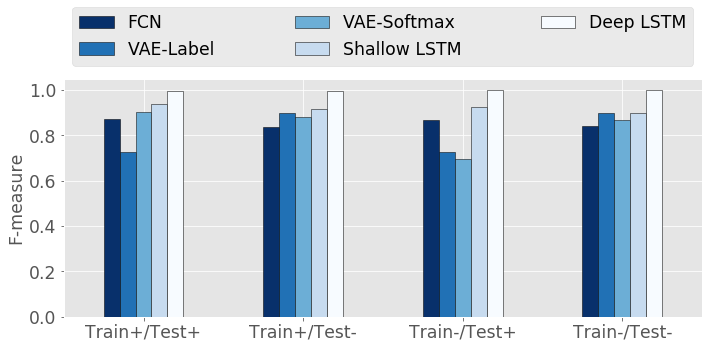

In [18]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large',
                                   edgecolor='black')
lgd = plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",  mode="expand", ncol=3, fontsize='xx-large')
plot_bar.set_xlabel("")
plot_bar.set_ylabel("F-measure", fontsize='xx-large')
#display_and_save("All Results with Train_Test in X-axis",plot_bar)
plot_bar.get_figure().savefig("result_plots/fig_b.png", format='png', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [19]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Train+/Test+,Train+/Test-,Train-/Test+,Train-/Test-
Model,,,,
FCN,0.8739,0.8350,0.8695,0.8396
LSTM-Seq2Seq,0.9955,0.9955,0.9993,0.9993
VAE-Label,0.7255,0.9001,0.7255,0.9001
VAE-Softmax,0.9036,0.8814,0.6942,0.8700


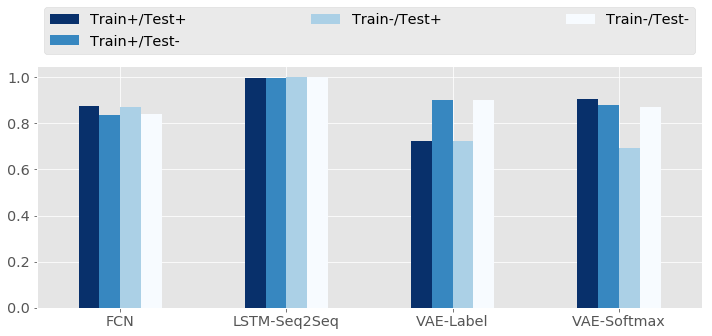

In [20]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='x-large')
plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
plot_bar.set_xlabel("")
display_and_save("All Results with Models in X Axis",plot_bar)


In [64]:
t = t_duration.drop('variable', axis=1)
t = t.set_index("LSTM Type").drop('Deep', axis=0).reset_index()
t.rename(columns={'LSTM Type':'Model', "value":"Duration(secs)"}, inplace=True)
t.replace({"Shallow":"Shallow LSTM"},inplace=True)
t

,Model,Duration(secs),Scenarios
0,Shallow LSTM,21.5624,Train+
1,Shallow LSTM,11.2495,Train-


In [65]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'Duration(secs)', 'Model']]
all_scenarios_display.replace('Train+/Test+', 'Train+', inplace=True)
all_scenarios_display.replace('Train+/Test-', 'Train+', inplace=True)
all_scenarios_display.replace('Train-/Test+', 'Train-', inplace=True)
all_scenarios_display.replace('Train-/Test-', 'Train-', inplace=True)
all_scenarios_display.replace({"LSTM-Seq2Seq":"Deep LSTM"},inplace=True)


all_scenarios_display = pd.concat([all_scenarios_display, t], axis=0)
all_scenarios_display

,Duration(secs),Model,Scenarios
1,18.9799,FCN,Train+
1,18.9799,FCN,Train+
1,0.6421,FCN,Train-
1,0.6421,FCN,Train-
1,1.8554,VAE-Label,Train+
1,1.8554,VAE-Label,Train+
1,2.1003,VAE-Label,Train-
1,2.1003,VAE-Label,Train-
1,88.6219,VAE-Softmax,Train+
1,88.6219,VAE-Softmax,Train+


In [74]:
all_scenarios_pivot = all_scenarios_display.pivot_table('Duration(secs)', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Train+,Train-
Model,,
Deep LSTM,24.9541,15.2373
FCN,18.9799,0.6421
Shallow LSTM,21.5624,11.2495
VAE-Label,1.8554,2.1003
VAE-Softmax,88.6219,10.4086


In [75]:
all_scenarios_pivot = all_scenarios_pivot.reindex(["FCN","VAE-Label","VAE-Softmax", "Shallow LSTM", "Deep LSTM"])
all_scenarios_pivot = all_scenarios_pivot.rename(index={'LSTM-Seq2Seq':"Deep LSTM"})
all_scenarios_pivot

Scenarios,Train+,Train-
Model,,
FCN,18.9799,0.6421
VAE-Label,1.8554,2.1003
VAE-Softmax,88.6219,10.4086
Shallow LSTM,21.5624,11.2495
Deep LSTM,24.9541,15.2373


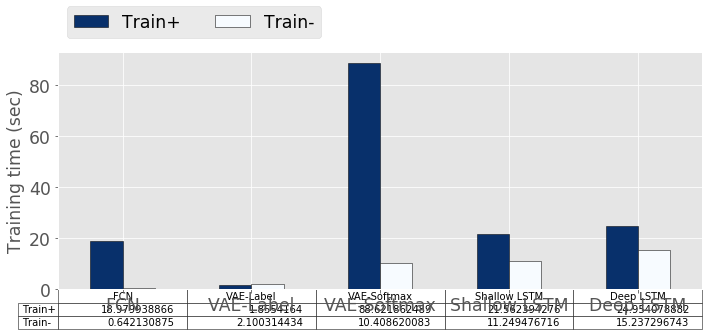

In [77]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0, legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large', 
                                    edgecolor='black')
lgd = plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, fontsize='xx-large')
plot_bar.set_xlabel("")
plot_bar.set_ylabel("Training time (sec)", fontsize='xx-large')
#display_and_save("All TimeTaken with Models in X Axis",plot_bar)
plot_bar.get_figure().savefig("result_plots/fig_a.png", format='png', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [25]:
%%bash
zip -r result_plots.zip result_plots

updating: result_plots/ (stored 0%)
updating: result_plots/Results for VAE-GenerateLabels Train-.png (deflated 16%)
updating: result_plots/Results for LSTM Train+.png (deflated 21%)
updating: result_plots/All Results with Models in X Axis.png (deflated 55%)
updating: result_plots/Results for VAE-GenerateLabels Train+.eps (deflated 71%)
updating: result_plots/Results for VAE-Softmax Train+.eps (deflated 70%)
updating: result_plots/All Results with Train_Test in X-axis.png (deflated 55%)
updating: result_plots/Results for VAE-GenerateLabels Train+.png (deflated 15%)
updating: result_plots/Results for VAE-Softmax Train-.eps (deflated 70%)
updating: result_plots/Results for Fully Connected Train+.png (deflated 19%)
updating: result_plots/Results for VAE-Softmax Train+.png (deflated 31%)
updating: result_plots/Results for LSTM Train+.eps (deflated 70%)
updating: result_plots/Results for LSTM Train-.png (deflated 21%)
updating: result_plots/All Results with Models in X Axis.eps (deflated 69%